# 3 Pre-processing Work and Model

## 3.1 Table of Contents
* [3.2 Import Libraries](#32-import-libraries)
* [3.3 Load the Data](#33-load-the-data)
* [3.4 Explore the Data](#34-explore-the-data)
* [3.5 Preprocessing Data](#35-preprocessing-data)
  * [3.5.1 Datetime Conversion and Indexing](#351-datetime-conversion-and-indexing)
  * [3.5.2 Cyclical Feature Transformation](#352-cyclical-feature-transformation)
  * [3.5.3 Dropping Redundant Columns](#353-dropping-redundant-columns)
  * [3.5.4 Check for Duplicate Timestamps](#354-check-for-duplicate-timestamps)
  * [3.5.5 Aggregate the Data](#355-aggregate-the-data)
  * [3.5.6 Resampling and Handling Missing Values](#356-resampling-and-handling-missing-values)
* [3.6 Decomposition and Statistical Testing](#36-decomposition-and-statistical-testing)
  * [3.6.1 ADF Test](#361-adf-test)
  * [3.6.2 KPSS Test](#362-kpss-test)
  * [3.6.3 Plot ACF and PACF](#363-plot-acf-and-pacf)
* [3.7 Modeling](#37-modeling)
  * [3.7.1 SARIMA](#371-sarima)
    * [3.7.1.1 Log Transformation](#3711-log-transformation)
    * [3.7.1.2 Split the Transformed Data](#3712-split-the-transformed-data)
    * [3.7.1.3 Making a SARIMA Model](#3713-making-a-sarima-model)
    * [3.7.1.4 Fine-Tuning a SARIMA Model](#3714-fine-tuning-a-sarima-model)
    * [3.7.1.5 Fitting and Forecasting with Optimal SARIMA Parameters](#3715-fitting-and-forecasting-with-optimal-sarima-parameters)
  * [3.7.2 Machine Learning Models](#372-machine-learning-models)
    * [3.7.2.1 Split Data](#3721-split-data)
    * [3.7.2.2 Scaling](#3722-scaling)
    * [3.7.2.3 Random Forest](#3723-random-forest)
      * [3.7.2.3.1 Making a k-fold cross-validation with hyperparameter tuning for the Random Forest](#37231-making-a-k-fold-cross-validation-with-hyperparameter-tuning-for-the-random-forest)
      * [3.7.2.3.2 Fitting and Forecasting with Optimal Random Forest Parameters](#37232-fitting-and-forecasting-with-optimal-random-forest-parameters)
    * [3.7.2.4 XGBoost](#3724-xgboost)
      * [3.7.2.4.1 Making a k-fold cross-validation with hyperparameter tuning for the XGBoost](#37241-making-a-k-fold-cross-validation-with-hyperparameter-tuning-for-the-xgboost)
      * [3.7.2.4.2 Fitting and Forecasting with Optimal XGBoost Parameters](#37242-fitting-and-forecasting-with-optimal-xgboost-parameters)
* [3.8 Model Comparison: Evaluating Performance Metrics](#38-model-comparison-evaluating-performance-metrics)


<a id='Imports'></a>
## 3.2 Import Libraries

In [1]:
# Import libraries

# Data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

# Time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
import itertools

# Machine learning models and utilities
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Math functions
import math
from math import sqrt
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score

import warnings
warnings.filterwarnings(action='ignore')

<a id="Load-Data"></a>
## 3.3 Load the Data

Our goal is to model solar power generation effectively. Therefore, we should consider filtering out nighttime data, specifically during hours when AC_POWER and irradiation is zero, to focus solely on the time periods when solar power generation is feasible.

In [2]:
# Load the filtered data from CSV file into a Pandas DataFrame named 'filter_df'
filtered_df = pd.read_csv('/Users/aysebusra/Desktop/Springboard/Capstone_3/filtered_data.csv')

<a id="Explore-the-Data"></a>
## 3.4 Explore the Data

In [3]:
# Display the dimensions of the filtered_df data
filtered_df.shape

(32022, 17)

The filtered data has 32,022 rows and 16 columns

In [4]:
# Display the first few rows of the filtered_df data
filtered_df.head()

,DATE_TIME,INVERTER,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DATE,TIME,DAY,MONTH,WEEK,HOURS,MINUTES,EFFICIENCY
0,2020-05-15 06:00:00,1,15.406667,14.860000,0.800000,2.429012e+06,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.451752
1,2020-05-15 06:00:00,2,14.773333,14.246667,0.733333,1.215279e+09,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.435018
2,2020-05-15 06:00:00,3,15.380000,14.840000,1.866667,2.247720e+09,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.488947
3,2020-05-15 06:00:00,4,14.973333,14.440000,1.000000,1.704251e+06,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.438112
4,2020-05-15 06:00:00,5,15.160000,14.633333,0.733333,1.994153e+07,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.525945


The filtered data has the following columns:'DATE_TIME', 'INVERTER', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'DATE', 'TIME', 'DAY', 'MONTH', 'WEEK', 'HOURS','MINUTES' and 'EFFICIENCY.

In [5]:
# Get an overview of the structure and characteristics of the filtered_df data
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32022 entries, 0 to 32021
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            32022 non-null  object 
 1   INVERTER             32022 non-null  int64  
 2   DC_POWER             32022 non-null  float64
 3   AC_POWER             32022 non-null  float64
 4   DAILY_YIELD          32022 non-null  float64
 5   TOTAL_YIELD          32022 non-null  float64
 6   AMBIENT_TEMPERATURE  32022 non-null  float64
 7   MODULE_TEMPERATURE   32022 non-null  float64
 8   IRRADIATION          32022 non-null  float64
 9   DATE                 32022 non-null  object 
 10  TIME                 32022 non-null  object 
 11  DAY                  32022 non-null  int64  
 12  MONTH                32022 non-null  int64  
 13  WEEK                 32022 non-null  int64  
 14  HOURS                32022 non-null  int64  
 15  MINUTES              32022 non-null 

There are no missing values in the dataset. Most of the data are numeric except for the ' DATE_TIME', ' DATE' and 'TIME' columns. Converting the ' DATE_TIME' column to datetime format will enable us to perform time-based analysis.

In [6]:
# Check for duplicate rows in the filtered_df data
duplicates = filtered_df.duplicated().sum()
print(f"Number of duplicate rows in filtered data: {duplicates}")

Number of duplicate rows in filtered data: 0


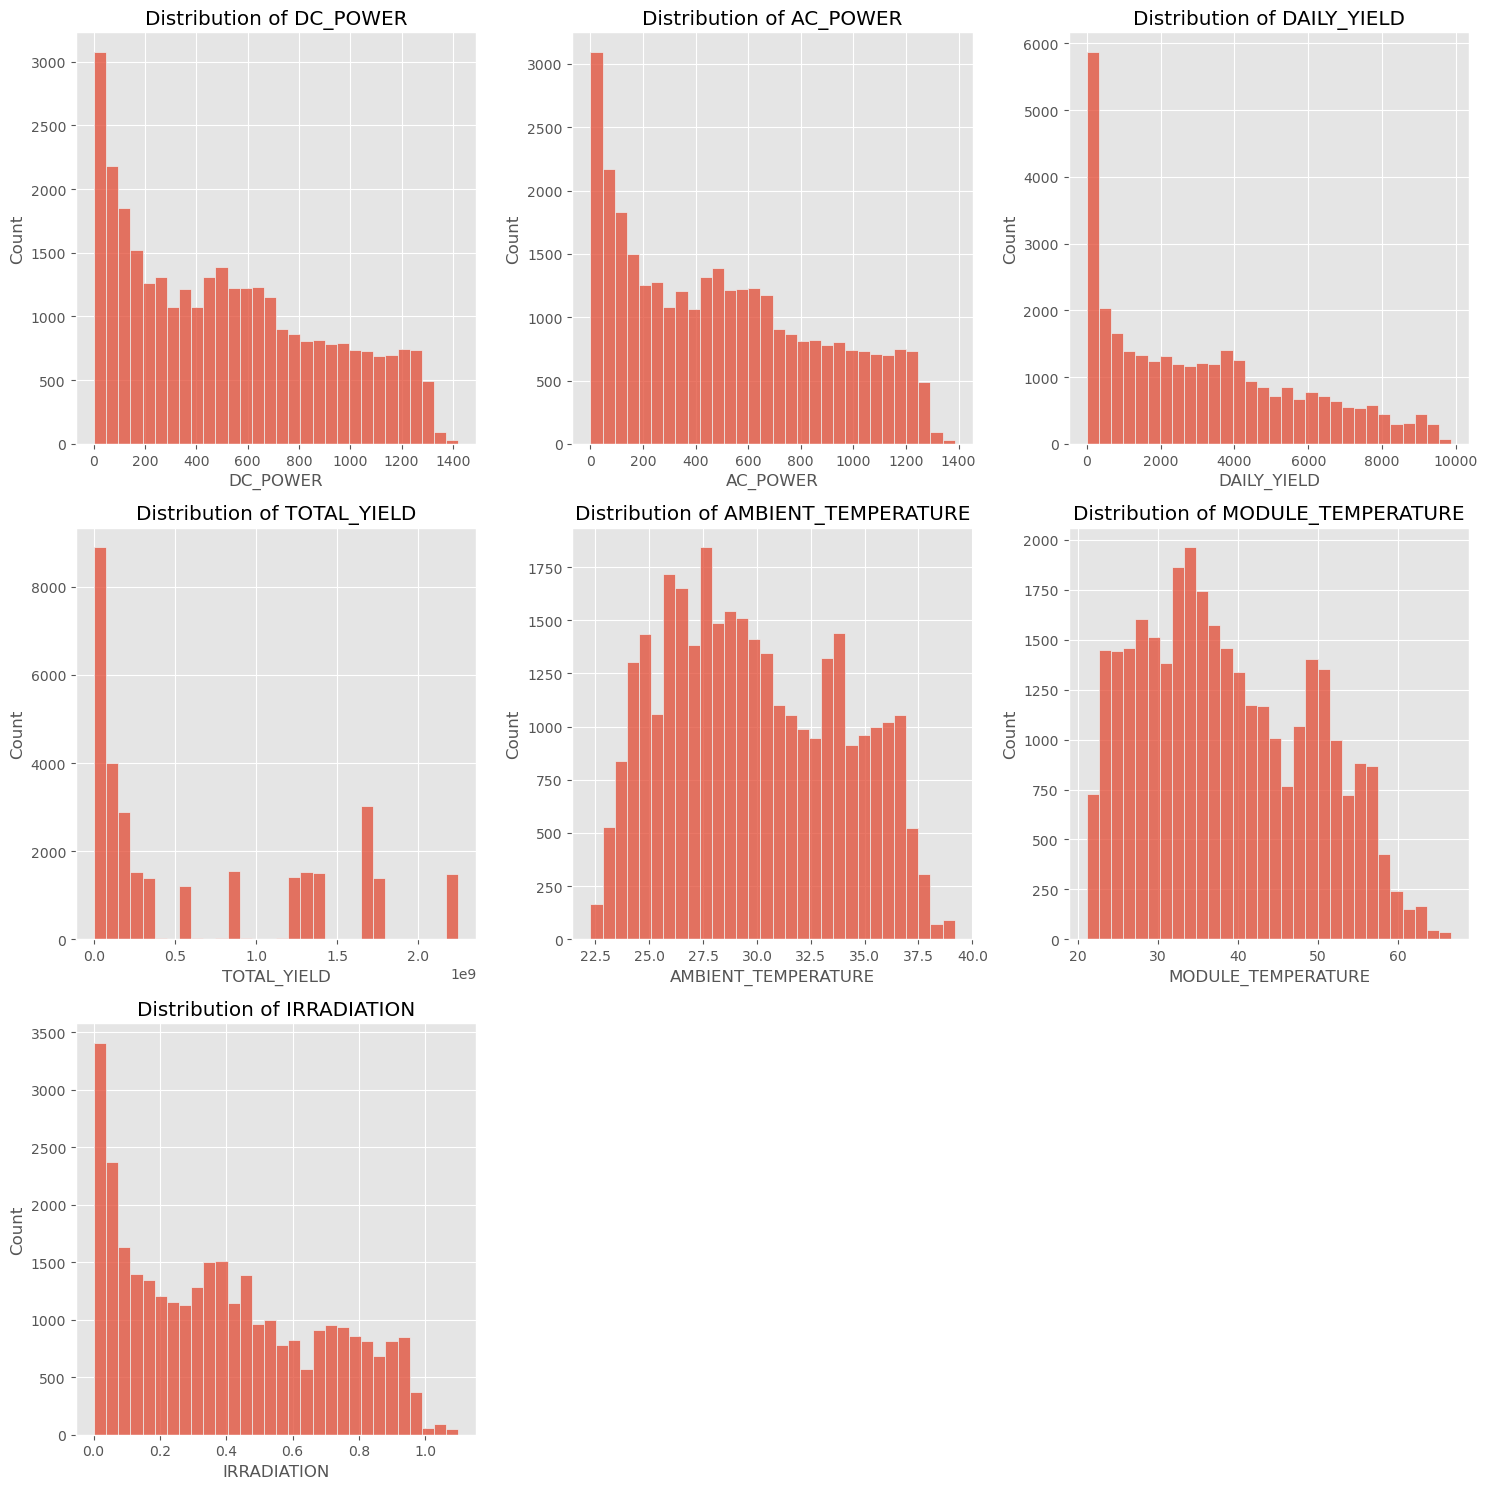

In [7]:
# List of numerical columns
filtered_numerical_columns = ['DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 
                              'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']


# Plot histograms for numerical columns
plt.figure(figsize=(15, 15))
for i, col in enumerate(filtered_numerical_columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(filtered_df[col], bins=30, alpha=0.75)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

Based on the histogram plot: 
* DC_POWER and AC_POWER are right-skewed.
* DAILY_YIELD is right-skewed, showing a more continuous range of values.
* The TOTAL_YIELD is right-skewed with noticeable peaks.
* AMBIENT_TEMPERATURE is approximately normal distribution centered around 27.5°C.
* MODULE_TEMPERATURE is right-skewed with most values between 20°C and 40°C.
* IRRADIATION is right-skewed, with most values between 0 and 1.

<a id='Preprocessing'></a>
## 3.5 Preprocessing Data

<a id="Convert-Datetime-Indexing"></a>
### 3.5.1 Datetime Conversion and Indexing

In [8]:
# Convert 'DATE_TIME' columns to Datetime in the filtered_df data
filtered_df['DATE_TIME'] = pd.to_datetime(filtered_df['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

# Set DATE_TIME as index
filtered_df.set_index(['DATE_TIME'], inplace=True)
filtered_df.head()

,INVERTER,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DATE,TIME,DAY,MONTH,WEEK,HOURS,MINUTES,EFFICIENCY
DATE_TIME,,,,,,,,,,,,,,,,
2020-05-15 06:00:00,1,15.406667,14.860000,0.800000,2.429012e+06,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.451752
2020-05-15 06:00:00,2,14.773333,14.246667,0.733333,1.215279e+09,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.435018
2020-05-15 06:00:00,3,15.380000,14.840000,1.866667,2.247720e+09,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.488947
2020-05-15 06:00:00,4,14.973333,14.440000,1.000000,1.704251e+06,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.438112
2020-05-15 06:00:00,5,15.160000,14.633333,0.733333,1.994153e+07,24.742787,24.07723,0.012962,2020-05-15,06:00:00,15,5,20,6,0,96.525945


<a id="Cyclical-Transformation"></a>
### 3.5.2 Cyclical Feature Transformation

Since both 'HOURS' and 'MINUTES' are cyclical,these features converted into sine and cosine components. This transformation helps the model to recognize the continuity at the end and start of each cycle.

In [9]:
# Transform the HOURS and MINUTES into cyclical features
filtered_df['HOURS_SIN'] = np.sin(filtered_df['HOURS'] * (2. * np.pi / 24))
filtered_df['HOURS_COS'] = np.cos(filtered_df['HOURS'] * (2. * np.pi / 24))
filtered_df['MINUTES_SIN'] = np.sin(filtered_df['MINUTES'] * (2. * np.pi / 60))
filtered_df['MINUTES_COS'] = np.cos(filtered_df['MINUTES'] * (2. * np.pi / 60))

<a id="Dropping"></a>
### 3.5.3 Dropping Redundant Columns

In [10]:
# Drop the 'DATE', 'TIME', 'HOURS', and 'MINUTES'column in the filtered_df data
filtered_df.drop(['DATE', 'TIME', 'HOURS', 'MINUTES'], axis=1, inplace=True)
filtered_df.head()

,INVERTER,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,MONTH,WEEK,EFFICIENCY,HOURS_SIN,HOURS_COS,MINUTES_SIN,MINUTES_COS
DATE_TIME,,,,,,,,,,,,,,,,
2020-05-15 06:00:00,1,15.406667,14.860000,0.800000,2.429012e+06,24.742787,24.07723,0.012962,15,5,20,96.451752,1.0,6.123234e-17,0.0,1.0
2020-05-15 06:00:00,2,14.773333,14.246667,0.733333,1.215279e+09,24.742787,24.07723,0.012962,15,5,20,96.435018,1.0,6.123234e-17,0.0,1.0
2020-05-15 06:00:00,3,15.380000,14.840000,1.866667,2.247720e+09,24.742787,24.07723,0.012962,15,5,20,96.488947,1.0,6.123234e-17,0.0,1.0
2020-05-15 06:00:00,4,14.973333,14.440000,1.000000,1.704251e+06,24.742787,24.07723,0.012962,15,5,20,96.438112,1.0,6.123234e-17,0.0,1.0
2020-05-15 06:00:00,5,15.160000,14.633333,0.733333,1.994153e+07,24.742787,24.07723,0.012962,15,5,20,96.525945,1.0,6.123234e-17,0.0,1.0


<a id="Duplicates"></a>
### 3.5.4 Check for Duplicate Timestamps

In [11]:
# Check for duplicate indices
filtered_df[filtered_df.index.duplicated(keep=False)] 

,INVERTER,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,MONTH,WEEK,EFFICIENCY,HOURS_SIN,HOURS_COS,MINUTES_SIN,MINUTES_COS
DATE_TIME,,,,,,,,,,,,,,,,
2020-05-15 06:00:00,1,15.406667,14.860000,0.800000,2.429012e+06,24.742787,24.077230,0.012962,15,5,20,96.451752,1.0,6.123234e-17,0.0,1.000000e+00
2020-05-15 06:00:00,2,14.773333,14.246667,0.733333,1.215279e+09,24.742787,24.077230,0.012962,15,5,20,96.435018,1.0,6.123234e-17,0.0,1.000000e+00
2020-05-15 06:00:00,3,15.380000,14.840000,1.866667,2.247720e+09,24.742787,24.077230,0.012962,15,5,20,96.488947,1.0,6.123234e-17,0.0,1.000000e+00
2020-05-15 06:00:00,4,14.973333,14.440000,1.000000,1.704251e+06,24.742787,24.077230,0.012962,15,5,20,96.438112,1.0,6.123234e-17,0.0,1.000000e+00
2020-05-15 06:00:00,5,15.160000,14.633333,0.733333,1.994153e+07,24.742787,24.077230,0.012962,15,5,20,96.525945,1.0,6.123234e-17,0.0,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-17 18:45:00,18,3.771429,3.635714,4156.857143,5.207579e+05,23.965923,23.283976,0.002635,17,6,25,96.401515,-1.0,-1.836970e-16,-1.0,-1.836970e-16
2020-06-17 18:45:00,19,2.857143,2.757143,3930.714286,1.211314e+08,23.965923,23.283976,0.002635,17,6,25,96.500000,-1.0,-1.836970e-16,-1.0,-1.836970e-16
2020-06-17 18:45:00,20,3.780000,3.633333,4321.800000,2.427691e+06,23.965923,23.283976,0.002635,17,6,25,96.119929,-1.0,-1.836970e-16,-1.0,-1.836970e-16


The duplicates in the dataset are likely due to simultaneous recordings from multiple inverters. Aggregating this data is beneficial, as it allows for a consistent analysis of inverter efficiency and helps identify overarching trends.

<a id="Aggregation"></a>
### 3.5.5 Aggregate the Data

In [12]:
# Aggregate the selected columns by taking the mean of each timestamp
selected_columns = ['AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE', 
                    'MODULE_TEMPERATURE', 'IRRADIATION']
aggregated_df = filtered_df.groupby('DATE_TIME')[selected_columns].mean()
aggregated_df.head()

,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,,
2020-05-15 06:00:00,14.565152,1.178788,6.449816e+08,24.742787,24.077230,0.012962
2020-05-15 06:15:00,25.771710,6.438312,6.449816e+08,24.763911,24.356189,0.021038
2020-05-15 06:30:00,56.525281,15.687662,6.449816e+08,24.786323,24.548886,0.042435
2020-05-15 06:45:00,153.348117,39.716450,6.449816e+08,25.048245,25.746662,0.103496
2020-05-15 07:00:00,300.653636,96.987879,6.449817e+08,25.673202,28.674707,0.199450


<a id="Resampling-Handling-Missing-Values"></a>
### 3.5.6 Resampling and Handling Missing Values

In [13]:
# Resample the aggregated data to regular 15-minute intervals
resampled_df = aggregated_df.resample('15T').asfreq()

# Check for missing values after resampling
resampled_df.isnull().sum()

AC_POWER               1499
DAILY_YIELD            1499
TOTAL_YIELD            1499
AMBIENT_TEMPERATURE    1499
MODULE_TEMPERATURE     1499
IRRADIATION            1499
dtype: int64

There are 1,499 missing values across all features after resampling, which suggests that no data was recorded during these 15-minute intervals.

In [14]:
# Interpolate missing timestamps
resampled_df.interpolate(method='linear', inplace=True)

In [15]:
# Check again for missing values
resampled_df.isnull().sum()

AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
dtype: int64

Confirmed that the resampled dataframe has no missing values across all of its columns after the interpolation operation.

<a id="Decomposition-Sttistical-Tests"></a>
## 3.6 Decomposition and Statistical Testing

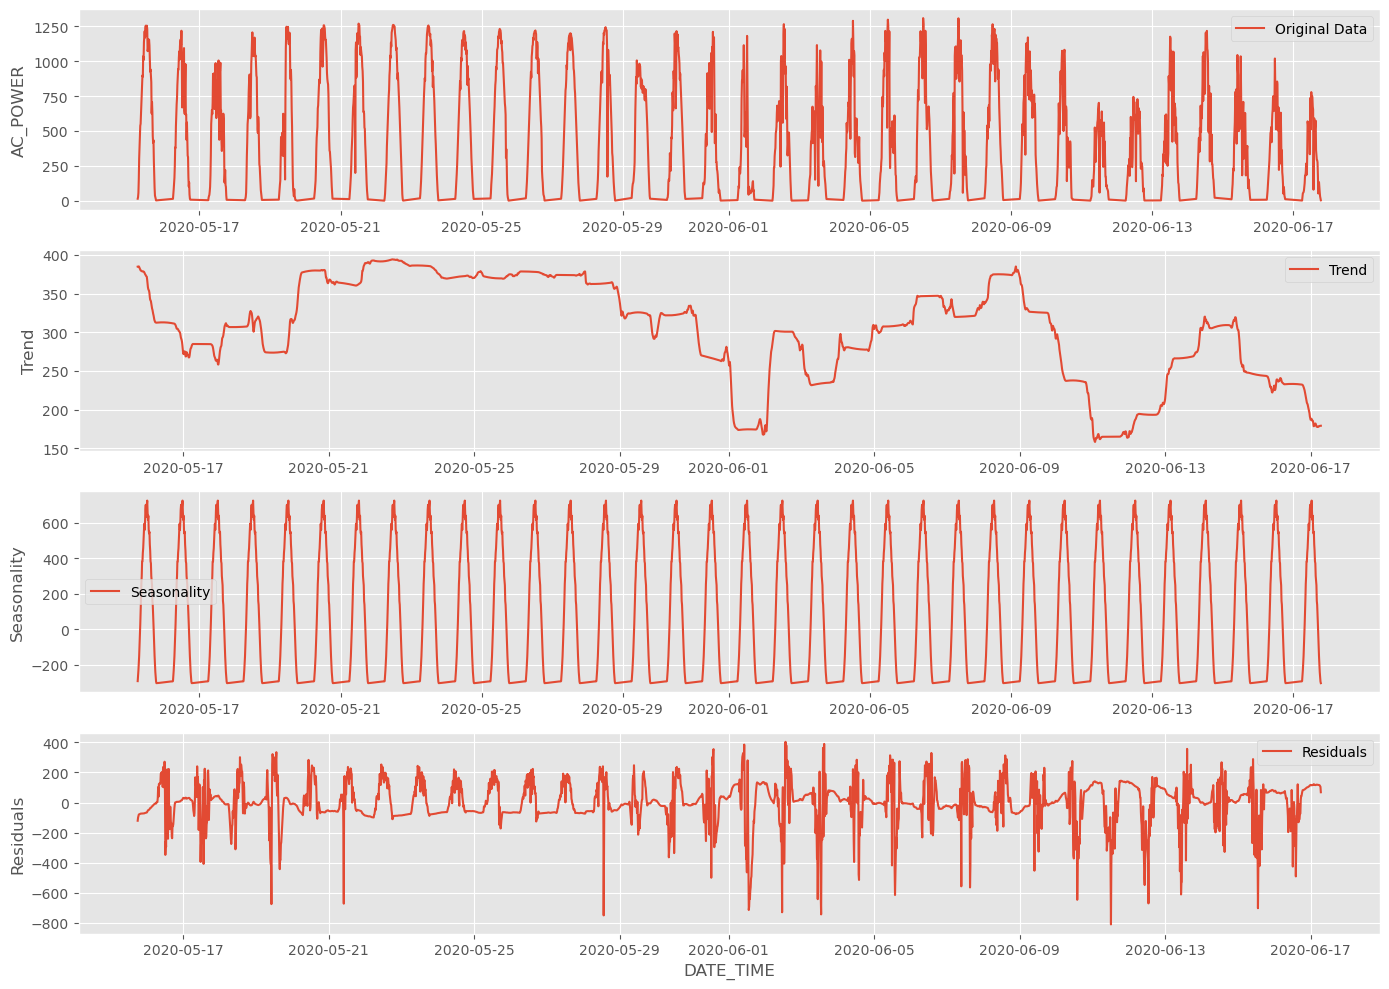

In [16]:
# Make a variable called decomposition, and assign it target variable and period passed to seasonal_decompose() 
decomposition = seasonal_decompose(resampled_df['AC_POWER'], period=96)

# Assign them the relevant features of decomposition 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.figure(figsize=(14,10))
plt.subplot(4,1,1)
plt.plot(resampled_df['AC_POWER'], label='Original Data')
plt.ylabel('AC_POWER')
plt.legend(loc = 'best')

plt.subplot(4,1,2)
plt.plot(trend, label='Trend')
plt.ylabel('Trend')
plt.legend(loc = 'best')

plt.subplot(4,1,3)
plt.plot(seasonal, label='Seasonality')
plt.ylabel('Seasonality')
plt.legend(loc = 'best')

plt.subplot(4,1,4)
plt.plot(residual, label='Residuals')
plt.legend(loc = 'best')
plt.ylabel('Residuals')
plt.xlabel('DATE_TIME')

plt.tight_layout()
plt.show()

* The original data shows fluctuations in AC_POWER generation, with clear peaks during daylight hours due to sunlight and drops to nearly zero at night.
* There is a noticeable decreasing trend in AC power output from May 15 to June 17, 2020, which may be attributed to seasonal changes or other external factors that impact efficiency.
* The seasonal plot displays a consistent pattern that matches the daily solar cycle, with peaks in midday solar generation and troughs at night when there is no solar activity.
* The residuals plot shows random fluctuations, suggesting that there are additional factors influencing power generation that are not captured by seasonal or trend components. These fluctuations could be due to weather conditions or operational issues.

<a id="ADF"></a>
### 3.6.1 ADF Test

In [17]:
# Applying the Augmented Dickey-Fuller (ADF) test on the 'AC_POWER' data
adf_test = adfuller(resampled_df['AC_POWER'])

print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])
print('Critical Values:', adf_test[4])

ADF Statistic: -14.046848502474456
p-value: 3.2293424716514176e-26
Critical Values: {'1%': -3.4323926176073427, '5%': -2.8624425047982394, '10%': -2.567250423444633}


* The ADF statistic is much lower than the critical values at common significance levels (1%, 5%, and 10%). This suggests a strong rejection of the null hypothesis. 
* The p-value is extremely small, which strongly indicates that reject the null hypothesis.
* The test results indicates that the time series is stationary. This means it can be modeled as is, without needing further differencing to stabilize the mean.

<a id="KPSS"></a>
### 3.6.2 KPSS Test

In [18]:
# Applying the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test on the 'AC_POWER' data
kpss_test = kpss(resampled_df['AC_POWER'])
print('KPSS Statistic:', kpss_test[0])
print('p-value:', kpss_test[1])
print('Critical Values:', kpss_test[3])

KPSS Statistic: 0.19517009520822529
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


* The KPSS statistic is below the critical values, and the p-value is above 0.05, which suggests that we fail to reject the null hypothesis of stationarity.
* Both tests confirm that time series data is stationary, so there is no need for differencing to achieve stationarity. 

<a id="ACF-PACF"></a>
### 3.6.3 Plot ACF and PACF

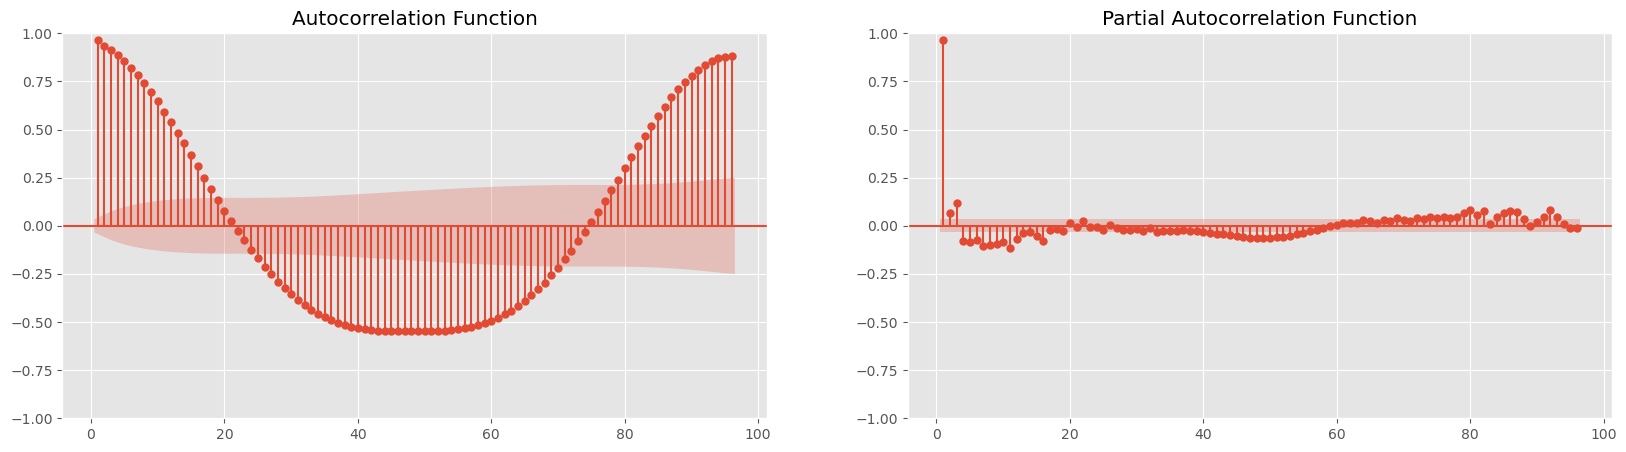

In [19]:
# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# Plot the Autocorrelation Function (ACF)
plot_acf(resampled_df['AC_POWER'], zero=False, ax=ax1, lags=96, alpha=0.05)
ax1.set_title('Autocorrelation Function')

# Plot the Partial Autocorrelation Function (PACF)
plot_pacf(resampled_df['AC_POWER'], zero=False, ax=ax2, lags=96, alpha=0.05)
ax2.set_title('Partial Autocorrelation Function')

plt.show()

* The ACF plot shows a wave-like pattern that gradually diminishes, suggesting seasonality in the data.
* The PACF plot has a significant spike at lag 1 and then quickly drops off, indicating a potential AR(1) component.
* Based on the plots:
    * AR (p): The significant spike at lag 1 in the PACF suggests an AR(1) component, so p=1.
    * Differencing (d): Since the series is already stationary, d=0.
    * MA (q): The ACF plot does not show a clear cutoff, suggesting q=0 or q=1.
    * Seasonal Parameters: Given the periodicity of 96 (15-minute intervals over a day), the seasonal component   should be included.

<a id="Modeling"></a>
## 3.7 Modeling

<a id="SARIMA"></a>
### 3.7.1 SARIMA Model

Since the data shows clear and strong daily seasonality, as indicated by decomposition, ACF and PACF plots, it would be more efficient to start directly with SARIMA model. 

<a id="Log-Transformation"></a>
#### 3.7.1.1 Log Transformation

Based on the distribution plots, some features have a right-skewed distribution. Log transformation is applied to stabilize variance and make the data more normally distributed.

In [20]:
# Apply log transformation to specified columns
columns_to_transform = ['AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'IRRADIATION']

for column in columns_to_transform:
    resampled_df[column] = np.log1p(resampled_df[column])
    
# Check the transformed columns
print(resampled_df[columns_to_transform].head())

                     AC_POWER  DAILY_YIELD  TOTAL_YIELD  IRRADIATION
DATE_TIME                                                           
2020-05-15 06:00:00  2.745035     0.778769    20.284732     0.012879
2020-05-15 06:15:00  3.287346     2.006644    20.284732     0.020819
2020-05-15 06:30:00  4.052225     2.814670    20.284732     0.041560
2020-05-15 06:45:00  5.039211     3.706632    20.284732     0.098483
2020-05-15 07:00:00  5.709279     4.584844    20.284732     0.181864


<a id="Split-Data"></a>
#### 3.7.1.2 Split the Transformed Data

In [21]:
# Define features and target
selected_columns = ['AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD','AMBIENT_TEMPERATURE', 
                    'MODULE_TEMPERATURE', 'IRRADIATION']

data = resampled_df[selected_columns]

# Split the data into features and target variable
X = data.drop('AC_POWER', axis=1)
y = data['AC_POWER']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Display the shapes of the resulting datasets
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2576, 5)
(644, 5)
(2576,)
(644,)


<a id="Sarima"></a>
#### 3.7.1.2 Making a SARIMA Model

In [22]:
# Define SARIMA model
sarima_model = SARIMAX(y_train, order=(1, 0, 0), 
                                       seasonal_order=(1, 1, 0, 96),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False)
sarima_model_fit = sarima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25575D-01    |proj g|=  6.00026D-01


 This problem is unconstrained.



At iterate    5    f=  2.11246D-01    |proj g|=  6.44801D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     17      1     0     0   4.233D-05   2.112D-01
  F =  0.21124136392590195     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [23]:
# Predict using SARIMA model
sarima_forecast = sarima_model_fit.forecast(steps=len(y_test))
sarima_forecast = pd.Series(sarima_forecast, index=y_test.index)

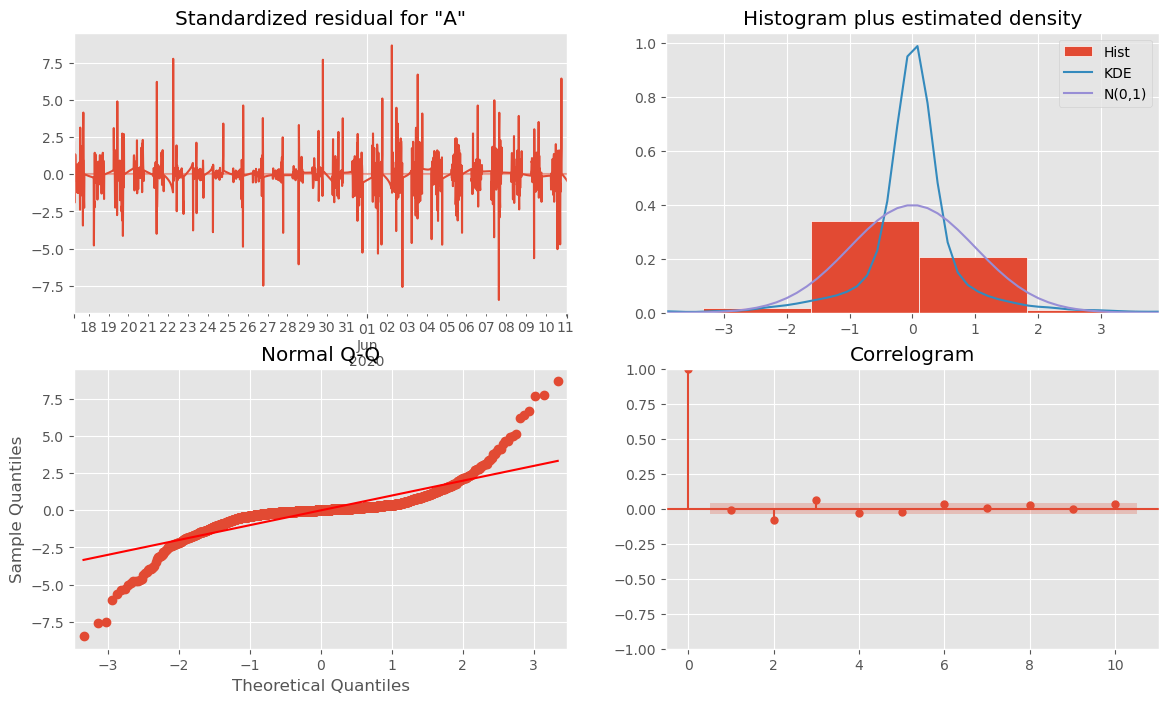

In [24]:
# Generate diagnostics plots
sarima_model_fit.plot_diagnostics(figsize=(14, 8))
plt.show()

* The residuals seem to have some noticeable spikes and patterns, indicating that the model might not have captured all the patterns in the data.
* The histogram plot show that the residuals have a peak around zero but are slightly skewed and do not perfectly match the normal distribution curve.
* The Q-Q plot shows some deviation from the reference line, especially in the tails, indicating that the residuals are not perfectly normal.
* In correlogram, for the non-zero lags, most autocorrelation values fall within the confidence intervals, indicating that there is no significant autocorrelation at these lags.

In [25]:
# Evaluate the SARIMA model
rmse = np.sqrt(mean_squared_error(y_test, sarima_forecast))
mape = np.mean(np.abs((y_test - sarima_forecast) / y_test)) * 100

print(f"SARIMA RMSE: {rmse}")
print(f"SARIMA MAPE: {mape}")

SARIMA RMSE: 0.7003579017653135
SARIMA MAPE: 23.381656179723027


* The average squared error of the predictions is 0.70. It means that the model's predictions deviate from the actual values by approximately 0.70 units of AC_POWER on average. 
* The model's predictions have an average percentage error of about 23.382%. This indicates that the model's predictions are, on average, 23.382% away from the actual values. This is relatively high and suggests that the SARIMA model may not be capturing the underlying patterns in the data as effectively as desired.

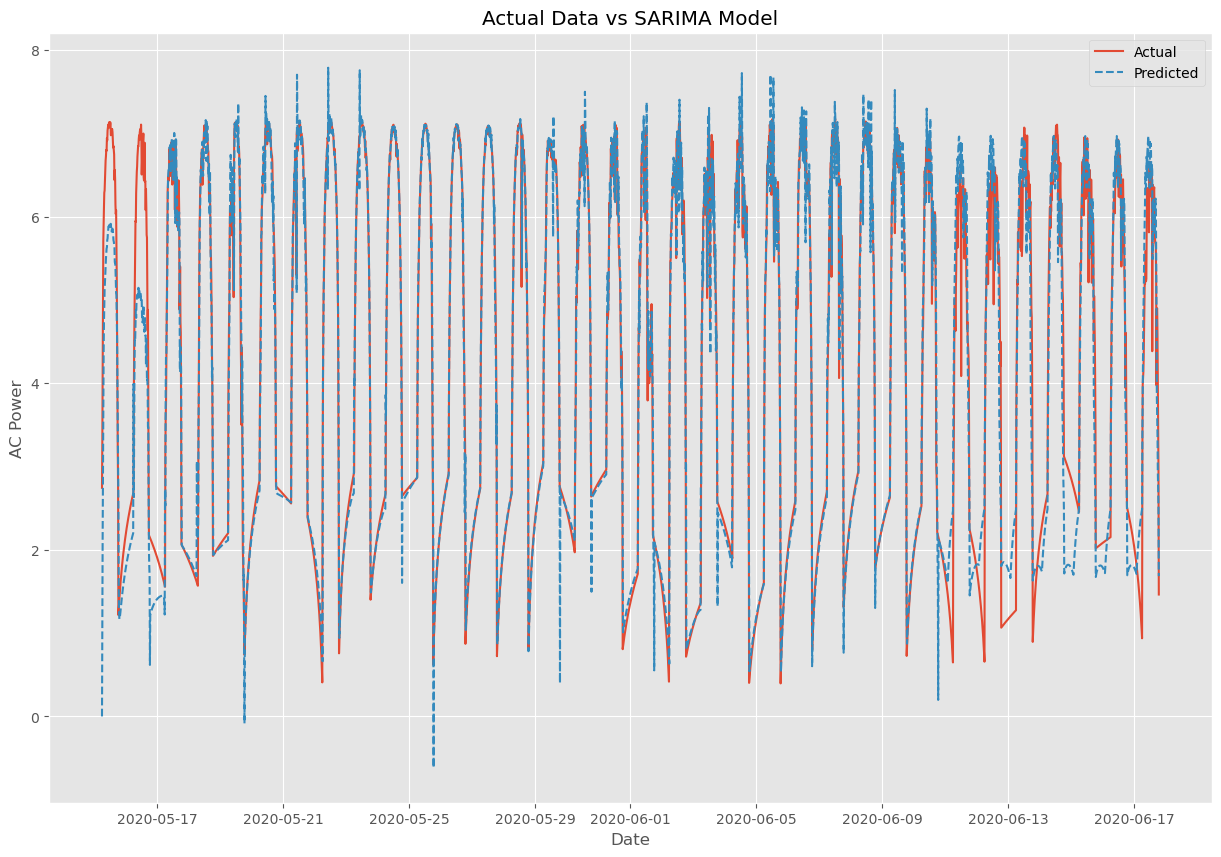

In [26]:
# Plot predicted vs actual values for SARIMA
plt.figure(figsize=(15,10))
plt.plot(resampled_df['AC_POWER'], label='Actual')
plt.plot(sarima_model_fit.predict(start=0, end=len(resampled_df)-1), linestyle='dashed', label='Predicted')
plt.title('Actual Data vs SARIMA Model')
plt.legend()
plt.xlabel('Date')
plt.ylabel('AC Power')
plt.show()

* The predicted values generally follow the trend of the actual values, indicating that the model is capturing the overall pattern and seasonal components.However, there are noticeable discrepancies between the actual and predicted values, especially during periods of rapid change or at the peaks and troughs. These discrepancies contribute to the relatively high RMSE and MAPE.

<a id="Tune-SARIMA"></a>
#### 3.7.1.3 Fine-Tuning a SARIMA Model

In [ ]:
# Use a smaller subset of the data for model selection
#subset_size = int(len(y_train) * 0.05)
#train_ac_power_subset = train_ac_power[:subset_size]

#auto_model = pm.auto_arima(y_train,
                           #start_p=0, max_p=3,     
                           #start_q=0, max_q=3,     
                           #d=1,                    
                           #start_P=0, max_P=3,    
                           #start_Q=0, max_Q=3,     
                           #D=1,                     
                           #seasonal=True,          
                           #m=96,               
                           #trace=True,
                           #error_action='ignore',   
                           #suppress_warnings=True,
                           #stepwise=True)          

#best_params = auto_model_subset.get_params()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[96]             : AIC=1908.383, Time=4.88 sec
 ARIMA(1,1,0)(1,1,0)[96]             : AIC=inf, Time=77.02 sec


In [28]:
# Define the range for p, d, q parameters
#p = d = q = range(0, 2)
#pdq = list(itertools.product(p, d, q))

# Define the range for seasonal parameters with a seasonal period of 96
#seasonal_pdq = [(x[0], x[1], x[2], 96) for x in pdq]

#best_aic = float("inf")
#best_params = None

# Iterate over all combinations of p, d, q and seasonal parameters
#for param in pdq:
#  for seasonal_param in seasonal_pdq:
#       try:
#           # Define the SARIMAX model
#           mod = SARIMAX(y_train,
#                          order=param,
#                          seasonal_order=seasonal_param,
#                          enforce_stationarity=False,
#                          enforce_invertibility=False)
#            
#            # Fit the model
#            results = mod.fit(disp=False)
            
            # Check if the current model has a lower AIC
#           if results.aic < best_aic:
#               best_aic = results.aic
#               best_params = (param, seasonal_param)
            
            # Print the model and its AIC
#           print('ARIMA{}x{}96 - AIC:{}'.format(param, seasonal_param, results.aic))
#       except:
#           continue

#print('Best model: ARIMA{}x{}96 - AIC:{}'.format(best_params[0], best_params[1], best_aic))

ARIMA(0, 0, 0)x(0, 0, 0, 96)96 - AIC:15238.532455999073
ARIMA(0, 0, 0)x(0, 0, 1, 96)96 - AIC:12164.133150325102
ARIMA(0, 0, 0)x(0, 1, 0, 96)96 - AIC:5623.995840962483
ARIMA(0, 0, 0)x(0, 1, 1, 96)96 - AIC:4309.319730363069
ARIMA(0, 0, 0)x(1, 0, 0, 96)96 - AIC:5601.313952467152
ARIMA(0, 0, 0)x(1, 0, 1, 96)96 - AIC:4489.734125269635
ARIMA(0, 0, 0)x(1, 1, 0, 96)96 - AIC:4882.939490679442
ARIMA(0, 0, 0)x(1, 1, 1, 96)96 - AIC:4387.277194288308
ARIMA(0, 0, 1)x(0, 0, 0, 96)96 - AIC:11868.664516696961
ARIMA(0, 0, 1)x(0, 0, 1, 96)96 - AIC:9165.746282414593
ARIMA(0, 0, 1)x(0, 1, 0, 96)96 - AIC:3590.5605599210667
ARIMA(0, 0, 1)x(0, 1, 1, 96)96 - AIC:2347.8755432483467
ARIMA(0, 0, 1)x(1, 0, 0, 96)96 - AIC:3564.232367504188
ARIMA(0, 0, 1)x(1, 0, 1, 96)96 - AIC:2455.1786402734915
ARIMA(0, 0, 1)x(1, 1, 0, 96)96 - AIC:2921.7568401302337
ARIMA(0, 0, 1)x(1, 1, 1, 96)96 - AIC:2427.2531623499945
ARIMA(0, 1, 0)x(0, 0, 0, 96)96 - AIC:1870.6861522708423
ARIMA(0, 1, 0)x(0, 0, 1, 96)96 - AIC:1441.037271175815
A

The optimal parameters were found to be ARIMA(1, 1, 1)x(0, 1, 1, 96), with an AIC of 503.6586. 

<a id="Fit-Forecast"></a>
#### 3.7.1.4 Fitting and Forecasting with Optimal SARIMA Parameters

In [27]:
# Define SARIMA model
sarima_model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(0, 1, 1, 96))
sarima_model_fit = sarima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98185D-01    |proj g|=  1.01601D+00


 This problem is unconstrained.



At iterate    5    f=  1.50255D-01    |proj g|=  1.21146D-01

At iterate   10    f=  1.24081D-01    |proj g|=  2.65346D-02

At iterate   15    f=  1.20255D-01    |proj g|=  9.12726D-02

At iterate   20    f=  1.09448D-01    |proj g|=  9.26107D-02

At iterate   25    f=  1.03953D-01    |proj g|=  1.60191D-02

At iterate   30    f=  1.03627D-01    |proj g|=  2.81175D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     42      1     0     0   2.809D-04   1.036D-01
  F =  0.10362707793273999     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [28]:
# Forecast using SARIMA model
sarima_forecast = sarima_model_fit.forecast(steps=len(y_test))
sarima_forecast = pd.Series(sarima_forecast, index=y_test.index)

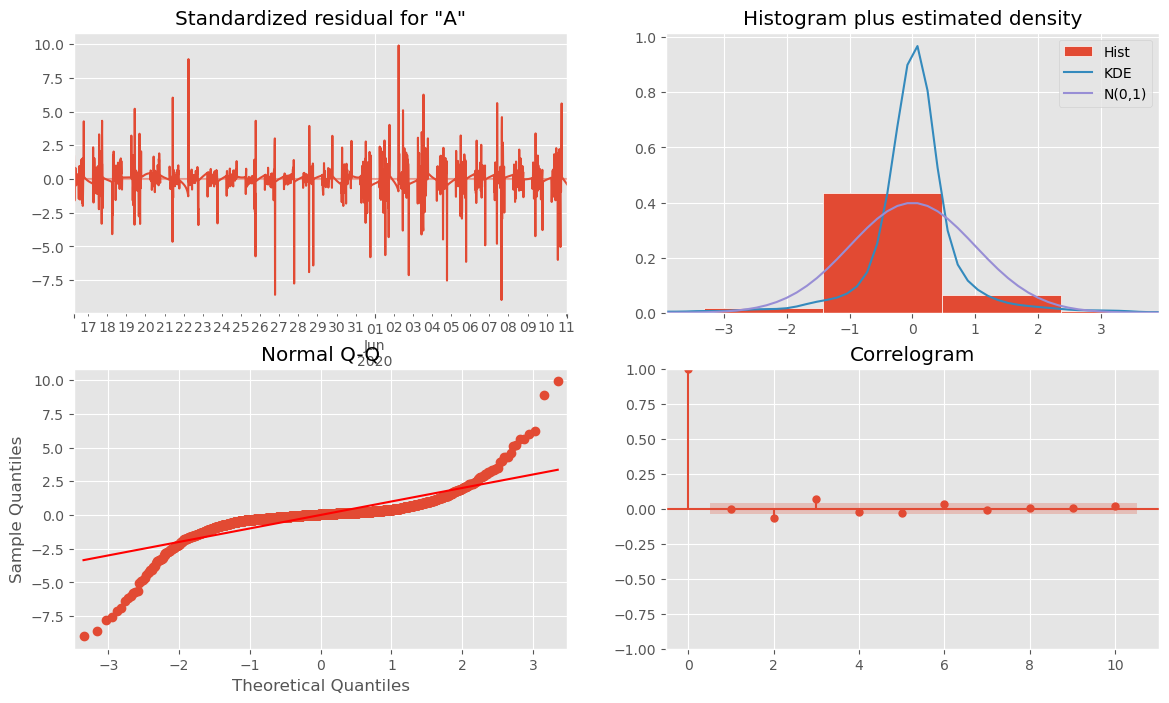

In [29]:
# Generate diagnostics plots
sarima_model_fit.plot_diagnostics(figsize=(14, 8))
plt.show()

In [30]:
# Evaluate the SARIMA model
rmse = np.sqrt(mean_squared_error(y_test, sarima_forecast))
mape = np.mean(np.abs((y_test - sarima_forecast) / y_test)) * 100

print(f"SARIMA RMSE: {rmse}")
print(f"SARIMA MAPE: {mape}")

SARIMA RMSE: 0.6083699165828909
SARIMA MAPE: 20.56981558989716


The Seasonal AutoRegressive Integrated Moving Average (SARIMA) model with the best parameters, ARIMA(1, 1, 1)x(0, 1, 1, 96), demonstrated improved performance over the initial model. The evaluation metrics for the optimized SARIMA model are as follows: RMSE of 0.608 and MAPE of 20.570%. These metrics indicate that the optimized model has better accuracy and lower error compared to the initial model.

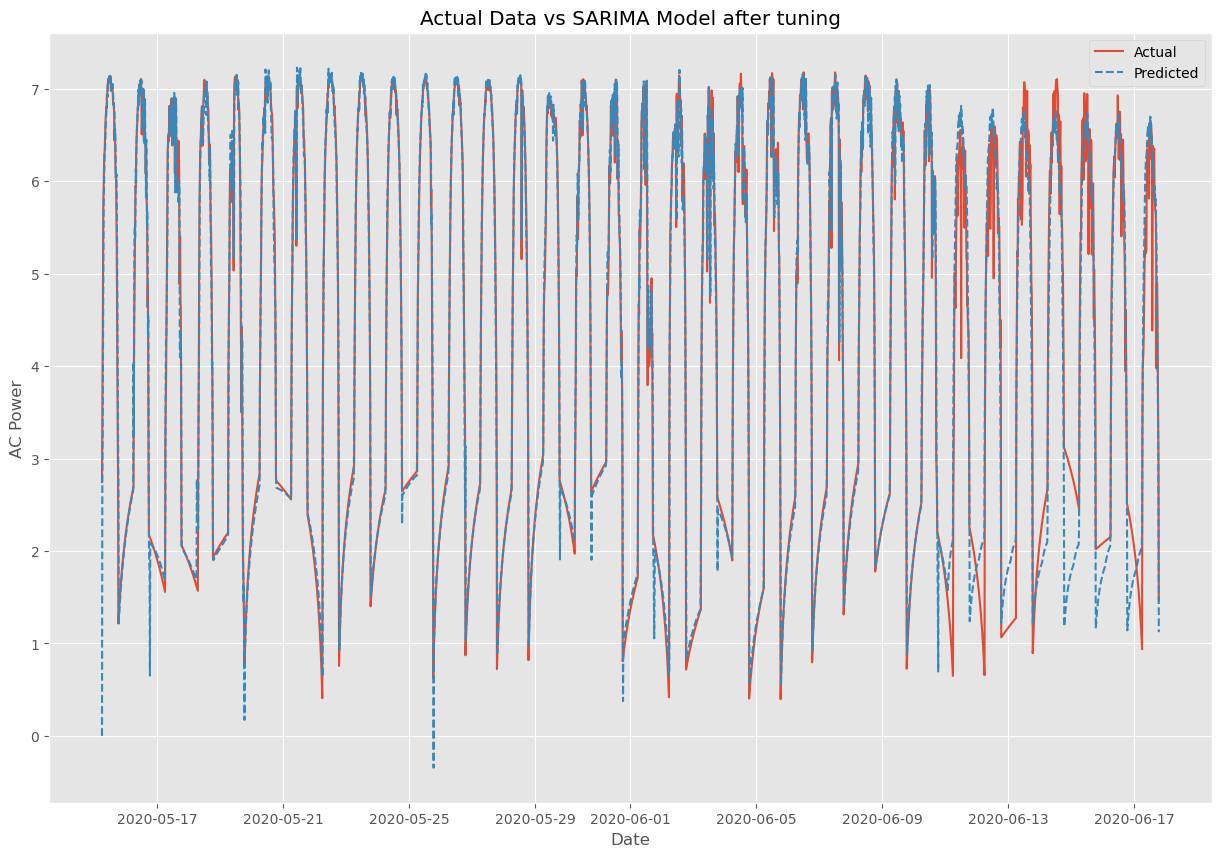

In [31]:
# Plot predicted vs actual values for SARIMA
plt.figure(figsize=(15,10))
plt.plot(resampled_df['AC_POWER'], label='Actual')
plt.plot(sarima_model_fit.predict(start=0, end=len(resampled_df)-1), linestyle='dashed', label='Predicted')
plt.title('Actual Data vs SARIMA Model after tuning')
plt.legend()
plt.xlabel('Date')
plt.ylabel('AC Power')
plt.show()

<a id="Machine Learning"></a>
### 3.7.2 Machine Learning Models

<a id="Splitting"></a>
#### 3.7.2.1 Split Data

In [32]:
# Define features and target
selected_columns = ['AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE', 
                    'MODULE_TEMPERATURE', 'IRRADIATION']
data = resampled_df[selected_columns]

In [33]:
# Split the data into features and target variable
X = data.drop('AC_POWER', axis=1)
y = data['AC_POWER']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Display the shapes of the resulting datasets
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2576, 5)
(644, 5)
(2576,)
(644,)


In [34]:
# Convert arrays to dataframes
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)
y_train_df = pd.DataFrame(y_train, columns=['AC_POWER'])
y_test_df = pd.DataFrame(y_test, columns=['AC_POWER'])

# Display the first few rows of the training and testing dataframes
print("X_train:")
print(X_train_df.head())

print("\nX_test:")
print(X_test_df.head())

print("\ny_train:")
print(y_train_df.head())

print("\ny_test:")
print(y_test_df.head())

X_train:
                     DAILY_YIELD  TOTAL_YIELD  AMBIENT_TEMPERATURE  \
DATE_TIME                                                            
2020-05-15 06:00:00     0.778769    20.284732            24.742787   
2020-05-15 06:15:00     2.006644    20.284732            24.763911   
2020-05-15 06:30:00     2.814670    20.284732            24.786323   
2020-05-15 06:45:00     3.706632    20.284732            25.048245   
2020-05-15 07:00:00     4.584844    20.284732            25.673202   

                     MODULE_TEMPERATURE  IRRADIATION  
DATE_TIME                                             
2020-05-15 06:00:00           24.077230     0.012879  
2020-05-15 06:15:00           24.356189     0.020819  
2020-05-15 06:30:00           24.548886     0.041560  
2020-05-15 06:45:00           25.746662     0.098483  
2020-05-15 07:00:00           28.674707     0.181864  

X_test:
                     DAILY_YIELD  TOTAL_YIELD  AMBIENT_TEMPERATURE  \
DATE_TIME                           

<a id="Scaling"></a>
#### 3.7.2.2 Scaling

In [35]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing data
X_test_scaled = scaler.transform(X_test)

# Display the shapes of the resulting datasets
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2576, 5)
(644, 5)
(2576,)
(644,)


<a id="Random-Forest"></a>
#### 3.7.2.3 Random Forest

In [36]:
# Initialize and train the Random Forest model
rf_model = RandomForestRegressor()
rf_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the Random Forest model
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100

print(f"Rondom Forest RMSE: {rmse_rf}")
print(f"Rondom Forest MAPE: {mape_rf}")

Rondom Forest RMSE: 0.14252830023277097
Rondom Forest MAPE: 4.387230190144899


* The RMSE indicates that, on average, the model's predictions are off by approximately 0.143 units in the log-transformed scale. This is a very low error, suggesting high accuracy.
* MAPE of 4.387% indicates that the model's predictions are, on average, about 4.39% off from the actual values. This is an excellent result, as a MAPE below 10% is generally considered very good.

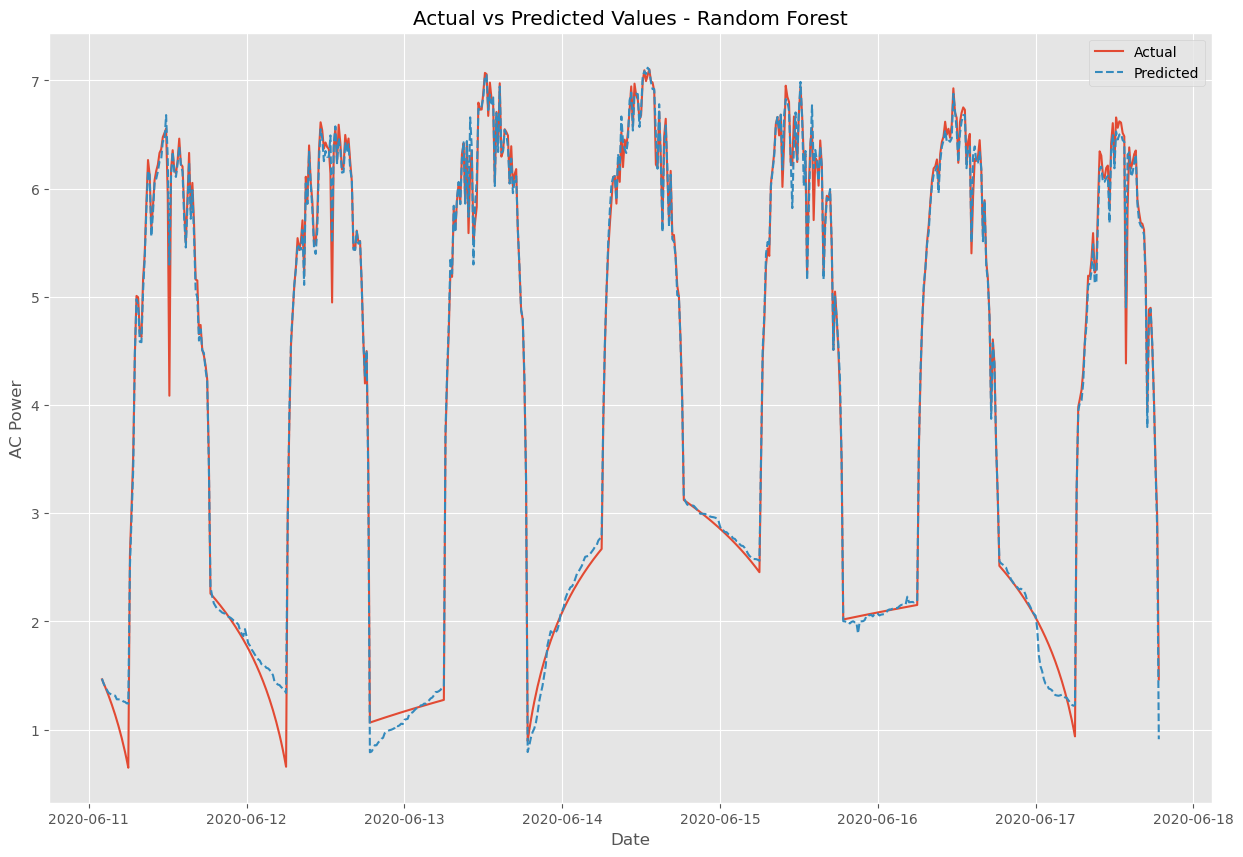

In [37]:
# Plot the predictions against the actual values for Random Forest
plt.figure(figsize=(15,10))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_rf, linestyle='dashed', label='Predicted')
plt.title('Actual vs Predicted Values - Random Forest')
plt.legend()
plt.xlabel('Date')
plt.ylabel('AC Power')
plt.show()

* The plot of predicted vs. actual values shows that the predicted values closely follow the actual values, indicating that the model captures the patterns in the data well.

<a id="Random-Forest-Tuning"></a>
##### 3.7.2.3.1 Making a k-fold cross-validation with hyperparameter tuning for the Random Forest

In [38]:
# Define the range of number of splits
num_splits_range = [3, 5, 7, 10]

# Dictionary to store cross-validation scores for each number of splits
cv_scores_rf_test = {}
cv_scores_rf_train = {}

for num_splits in num_splits_range:
    # Define cross-validation strategy with the current number of splits
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)
    
    # Define the Random Forest Regression model
    rf_model = RandomForestRegressor()
    
    # Perform hyperparameter tuning with GridSearchCV
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train.values.ravel())
    
    # Print best estimator and best score
    print(f"{num_splits}-fold Cross-Validation Best Estimator:")
    print(grid_search.best_estimator_)
    print(f"{num_splits}-fold Cross-Validation Best Score (RMSE):")
    print(-grid_search.best_score_)
    
    # Get the best model
    best_rf_model = grid_search.best_estimator_
    
    # Evaluate the best model using cross-validation on the training set
    cv_scores_rf_train[num_splits] = cross_val_score(best_rf_model, X_train_scaled, y_train, cv=kf, scoring='neg_root_mean_squared_error')
    
    # Evaluate the best model using cross-validation on the testing set
    cv_scores_rf_test[num_splits] = cross_val_score(best_rf_model, X_test_scaled, y_test, cv=kf, scoring='neg_root_mean_squared_error')

# Print the cross-validation scores for each number of splits
for num_splits in num_splits_range:
    print(f"{num_splits}-fold Cross-Validation Scores (RMSE):")
    
    # Mean cross-validation score on the training set
    mean_cv_score_train = -np.mean(cv_scores_rf_train[num_splits])
    print("Mean cross-validation RMSE score on training set:", mean_cv_score_train)
    
    # Mean cross-validation score on the testing set
    mean_cv_score_test = -np.mean(cv_scores_rf_test[num_splits])
    print("Mean cross-validation RMSE score on testing set:", mean_cv_score_test)
    
    # Standard deviation in cross-validation scores on the testing set
    std_cv_score_test = np.std(cv_scores_rf_test[num_splits])
    print("Standard deviation in cross-validation RMSE scores on testing set:", std_cv_score_test)


3-fold Cross-Validation Best Estimator:
RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=200)
3-fold Cross-Validation Best Score (RMSE):
0.11143011580564528
5-fold Cross-Validation Best Estimator:
RandomForestRegressor(max_features='sqrt', n_estimators=300)
5-fold Cross-Validation Best Score (RMSE):
0.10778303467006342
7-fold Cross-Validation Best Estimator:
RandomForestRegressor(max_depth=20, max_features='log2', n_estimators=300)
7-fold Cross-Validation Best Score (RMSE):
0.10480175967668229
10-fold Cross-Validation Best Estimator:
RandomForestRegressor(max_features='sqrt', n_estimators=300)
10-fold Cross-Validation Best Score (RMSE):
0.10350577169989221
3-fold Cross-Validation Scores (RMSE):
Mean cross-validation RMSE score on training set: 0.11318954505213437
Mean cross-validation RMSE score on testing set: 0.14805578898986757
Standard deviation in cross-validation RMSE scores on testing set: 0.030762226141000198
5-fold Cross-Validation Scores (RMSE):
Mean cros

In [39]:
# Create a dictionary to hold the data
data = {
    "Cross-Validation": ["3-fold", "5-fold", "7-fold", "10-fold"],
    "Max Depth": [20, None, 20, None],
    "Max Features": ["sqrt", "sqrt", "log2", "sqrt"],
    "N_Estimators": [200, 300, 300, 300],
    "Best RMSE Score": [0.1114, 0.1078, 0.1048, 0.1035],
    "Mean CV on Training Set": [0.1131, 0.1088, 0.1055, 0.1034],
    "Mean CV on Testing Set": [0.1481, 0.1453, 0.1384, 0.1326],
    "Standard Deviation on Testing Set": [0.0308, 0.0342, 0.0433, 0.0405]
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Set the title
title = "Random Forest Model Cross-Validation Results"

# Display the title and DataFrame
print(title)
df

Random Forest Model Cross-Validation Results


,Cross-Validation,Max Depth,Max Features,N_Estimators,Best RMSE Score,Mean CV on Training Set,Mean CV on Testing Set,Standard Deviation on Testing Set
0,3-fold,20.0,sqrt,200,0.1114,0.1131,0.1481,0.0308
1,5-fold,NaN,sqrt,300,0.1078,0.1088,0.1453,0.0342
2,7-fold,20.0,log2,300,0.1048,0.1055,0.1384,0.0433
3,10-fold,NaN,sqrt,300,0.1035,0.1034,0.1326,0.0405


* The Random Forest model consistently perform well across different cross-validation splits.
* The best RMSE score improves as the number of splits increases, indicating that using more folds provides a better estimate of the model's performance.
* The 10-fold cross-validation achieves the best RMSE score, suggesting it provides the most reliable estimate among the tested configurations.
* The RMSE on the training set decreases slightly with increasing number of splits, indicating the model is learning effectively.
* The RMSE on the testing set also decreases with increasing number of splits, indicating improved model performance and generalization.
* The standard deviation of RMSE on the testing set indicates variability in model performance across different splits. Lower standard deviation suggests more consistent performance.

<a id="Random-Forest-Optimal-Parameters"></a>
##### 3.7.2.3.2 Fitting and Forecasting with Optimal Random Forest Parameters

In [52]:
# Initialize and train the Random Forest model with the best parameters
best_rf_model = RandomForestRegressor(max_features='sqrt',
                      n_estimators=300, random_state=42)
best_rf_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_rf = best_rf_model.predict(X_test_scaled)

# Evaluate the Random Forest model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mape = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100

print(f"Random Forest RMSE: {rmse}")
print(f"Random Forest MAPE: {mape}")

Random Forest RMSE: 0.16455077062609808
Random Forest MAPE: 4.652501169612477


* The RMSE increased from 0.143 to 0.165, suggesting that the tuning process might have introduced more complexity. This indicates that the model's predictions are slightly less accurate after tuning. 
* The MAPE increased from 4.387% to 4.653%. The percentage error in predictions has also increased slightly. This further suggests that the model's accuracy has decreased marginally after tuning.

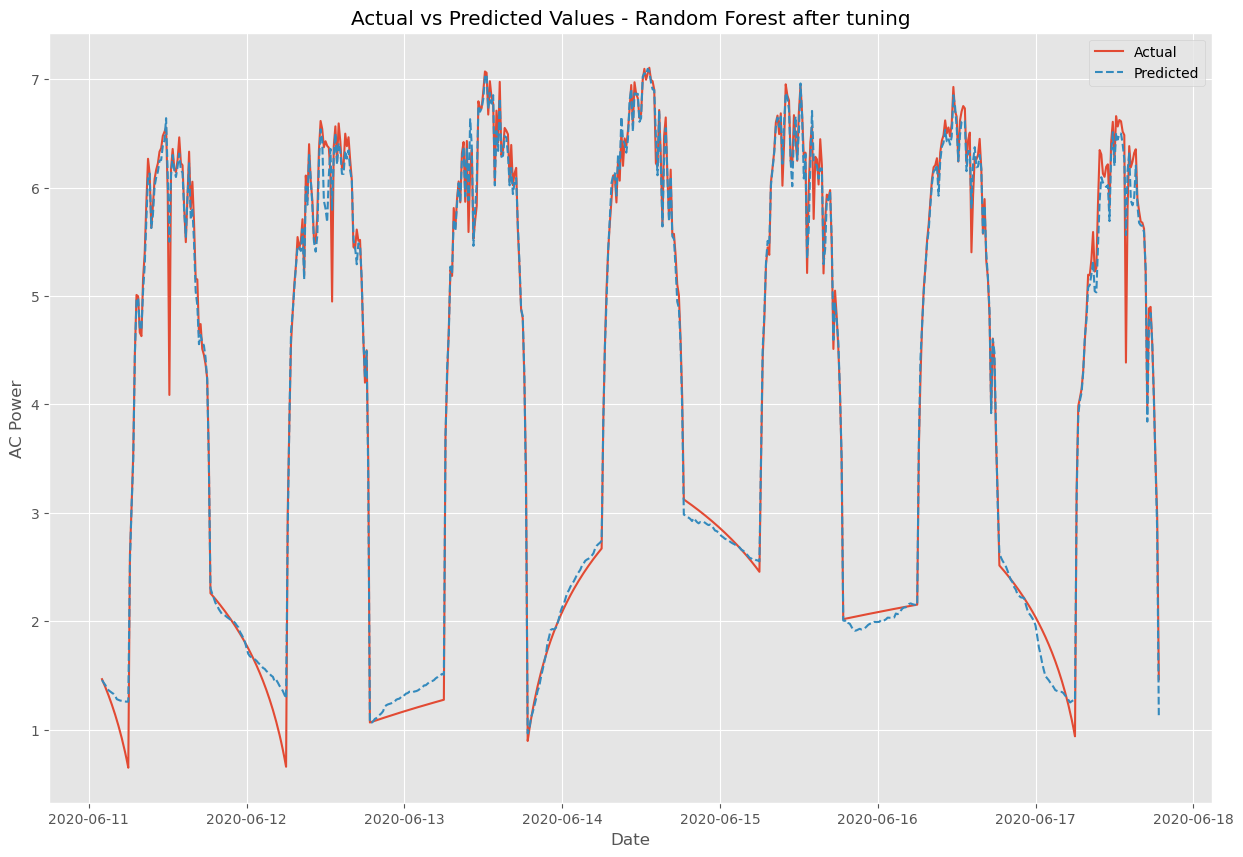

In [53]:
# Plot the predictions against the actual values for Random Forest
plt.figure(figsize=(15,10))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_rf, linestyle='dashed', label='Predicted')
plt.title('Actual vs Predicted Values - Random Forest after tuning')
plt.legend()
plt.xlabel('Date')
plt.ylabel('AC Power')
plt.show()

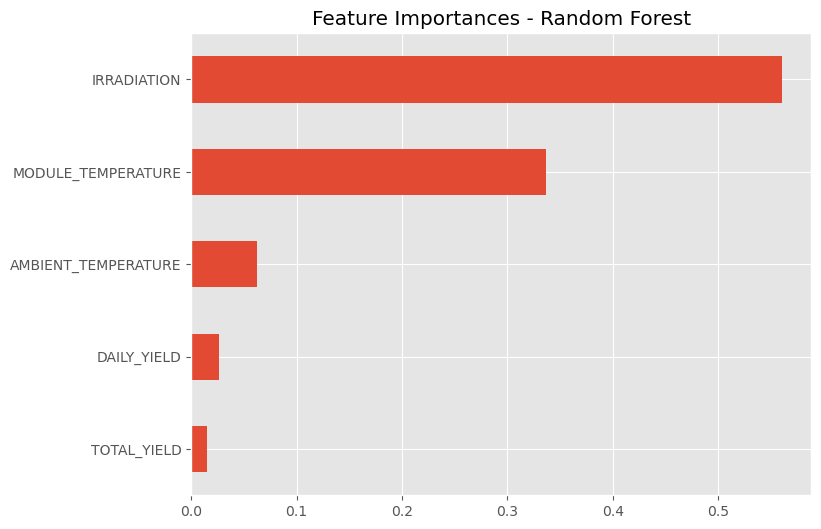

In [54]:
# Get feature importances from the trained Random Forest model
importances = best_rf_model.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names)
feature_importances.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title('Feature Importances - Random Forest')
plt.show()

* IRRADIATION is the most critical feature, accounting for approximately 60% of the importance. This suggests that the amount of irradiation is the primary driver of the model’s predictions. MODULE_TEMPERATURE is the second most important feature with around 35%, indicating that the efficiency of solar panels is strongly affected by their temperature. AMBIENT_TEMPERATURE also plays a role, contributing about 7.5%, as it can impact the overall environment and performance of the solar panels. DAILY_YIELD has a lower importance but still contributes to the model.TOTAL_YIELD has the least importance among the features.

<a id="XGBoost"></a>
#### 3.7.2.4 XGBoost

In [55]:
# Initialize and train the XGBoost model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate the XGBoost model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mape = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100

print(f"XGBoost RMSE: {rmse}")
print(f"XGBoost MAPE: {mape}")

XGBoost RMSE: 0.13506045640366973
XGBoost MAPE: 4.454984148636895


* RMSE value of 0.135 indicates that, on average, the XGBoost model's predictions are off by approximately 0.135 units in the log-transformed scale. This is a very low error, suggesting high accuracy and slightly better performance than the Random Forest model.
* MAPE value of 4.455% ndicates that, on average, the XGBoost model's predictions are about 4.455% off from the actual values. This MAPE is similar to the Random Forest model's performance and is generally considered very good, indicating that the model is performing well.

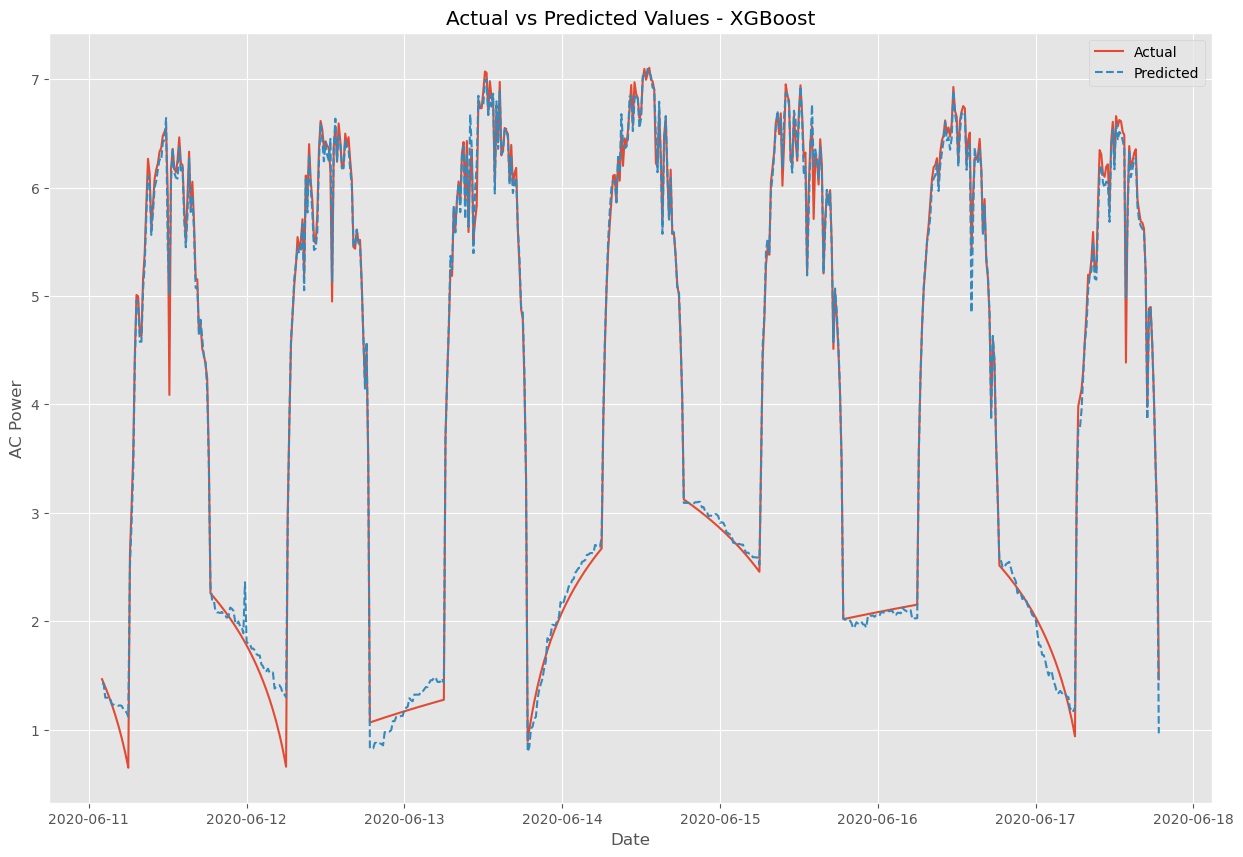

In [56]:
# Plot the predictions against the actual values for XGBoost
plt.figure(figsize=(15,10))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_xgb, linestyle='dashed', label='Predicted')
plt.title('Actual vs Predicted Values - XGBoost')
plt.legend()
plt.xlabel('Date')
plt.ylabel('AC Power')
plt.show()

* The XGBoost model’s predictions align very well with the actual values, particularly during peak and trough periods, demonstrating its ability to handle the daily cyclical patterns effectively.

<a id="XGboost-Tuning"></a>
##### 3.7.2.4.1 Making a k-fold cross-validation with hyperparameter tuning for the XGBoost

In [57]:
# Define the range of number of splits
num_splits_range = [3, 5, 7, 10]

# Dictionary to store cross-validation scores for each number of splits
cv_scores_xgb_test = {}
cv_scores_xgb_train = {}

for num_splits in num_splits_range:
    # Define cross-validation strategy with the current number of splits
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)
    
    # Define the XGBoost Regression model
    xgb_model = xgb.XGBRegressor()
    
    # Perform hyperparameter tuning with GridSearchCV
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1]
        
    }
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train.values.ravel())
    
    # Print best estimator and best score
    print(f"{num_splits}-fold Cross-Validation Best Estimator:")
    print(grid_search.best_estimator_)
    print(f"{num_splits}-fold Cross-Validation Best Score (RMSE):")
    print(-grid_search.best_score_)
    
    # Get the best model
    best_xgb_model = grid_search.best_estimator_
    
    # Evaluate the best model using cross-validation on the training set
    cv_scores_xgb_train[num_splits] = cross_val_score(best_xgb_model, X_train_scaled, y_train, cv=kf, scoring='neg_root_mean_squared_error')
    
    # Evaluate the best model using cross-validation on the testing set
    cv_scores_xgb_test[num_splits] = cross_val_score(best_xgb_model, X_test_scaled, y_test, cv=kf, scoring='neg_root_mean_squared_error')

# Print the cross-validation scores for each number of splits
for num_splits in num_splits_range:
    print(f"{num_splits}-fold Cross-Validation Scores (RMSE):")
    
    # Mean cross-validation score on the training set
    mean_cv_score_train = -np.mean(cv_scores_xgb_train[num_splits])
    print("Mean cross-validation RMSE score on training set:", mean_cv_score_train)
    
    # Mean cross-validation score on the testing set
    mean_cv_score_test = -np.mean(cv_scores_xgb_test[num_splits])
    print("Mean cross-validation RMSE score on testing set:", mean_cv_score_test)
    
    # Standard deviation in cross-validation scores on the testing set
    std_cv_score_test = np.std(cv_scores_xgb_test[num_splits])
    print("Standard deviation in cross-validation RMSE scores on testing set:", std_cv_score_test)

3-fold Cross-Validation Best Estimator:
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
3-fold Cross-Validation Best Score (RMSE):
0.08695092745245896
5-fold Cross-Validation Best Estimator:
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=N

In [58]:
# Define the data
data = {
    "Cross-Validation": ["3-fold", "5-fold", "7-fold", "10-fold"],
    "Max Depth": [5, 5, 5, 5],
    "N Estimators": [300, 300, 300, 300],
    "Learning Rate": [0.1, 0.1, 0.1, 0.1],
    "Best RMSE Score": [0.0870, 0.0803, 0.0854, 0.0789],
    "Mean CV Score on Training Set": [0.0869, 0.08031, 0.0854, 0.0789],
    "Mean CV Score on Testing Set": [0.1021, 0.0968, 0.0887, 0.0899],
    "Standard Deviation on Testing Set": [0.0041, 0.0227, 0.0221, 0.0318]
}

# Create DataFrame
df = pd.DataFrame(data)

# Set the title
title = "XGBoost Model Cross-Validation Results"

# Display the title and DataFrame
print(title)
df

XGBoost Model Cross-Validation Results


,Cross-Validation,Max Depth,N Estimators,Learning Rate,Best RMSE Score,Mean CV Score on Training Set,Mean CV Score on Testing Set,Standard Deviation on Testing Set
0,3-fold,5,300,0.1,0.0870,0.08690,0.1021,0.0041
1,5-fold,5,300,0.1,0.0803,0.08031,0.0968,0.0227
2,7-fold,5,300,0.1,0.0854,0.08540,0.0887,0.0221
3,10-fold,5,300,0.1,0.0789,0.07890,0.0899,0.0318


* Across all cross-validation folds, the best estimator consistently uses the parameters learning_rate=0.1, max_depth=5, and n_estimators=300.
* The RMSE scores improve as the number of folds increases, with the best score being 0.0789 for the 10-fold cross-validation. This suggests that using more folds provides a better estimate of the model's performance and might help in achieving lower error rates.
* The training set RMSE consistently shows lower error rates compared to the testing set, which is expected. The difference between training and testing RMSE indicates the model’s generalization performance.
* The smallest difference between training and testing RMSE is observed in the 7-fold cross-validation, indicating good generalization.
* The 3-fold cross-validation has the lowest standard deviation, indicating the most consistent performance across folds, while the 10-fold cross-validation has the highest standard deviation.

<a id="XGBoost-Optimal-Parameters"></a>
##### 3.7.2.4.2 Fitting and Forecasting with Optimal XGBoost Parameters

In [59]:
# Initialize and train the XGBoost model
xgb_model = xgb.XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=300)
xgb_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate the XGBoost model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mape = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100

print(f"XGBoost RMSE: {rmse}")
print(f"XGBoost MAPE: {mape}")

XGBoost RMSE: 0.1247253537925732
XGBoost MAPE: 4.065365700191261


* The model's predictions are off by approximately 0.125 units on average in the log-transformed scale. This is a lower error compared to the previous untuned XGBoost model (0.135) and the Random Forest model (0.162), indicating improved accuracy after tuning.
* The model's predictions have an average percentage error of about 4.065%. This is a significant improvement compared to the previous untuned XGBoost model (4.455%) and the Random Forest model (4.39%), indicating better performance in terms of percentage error.

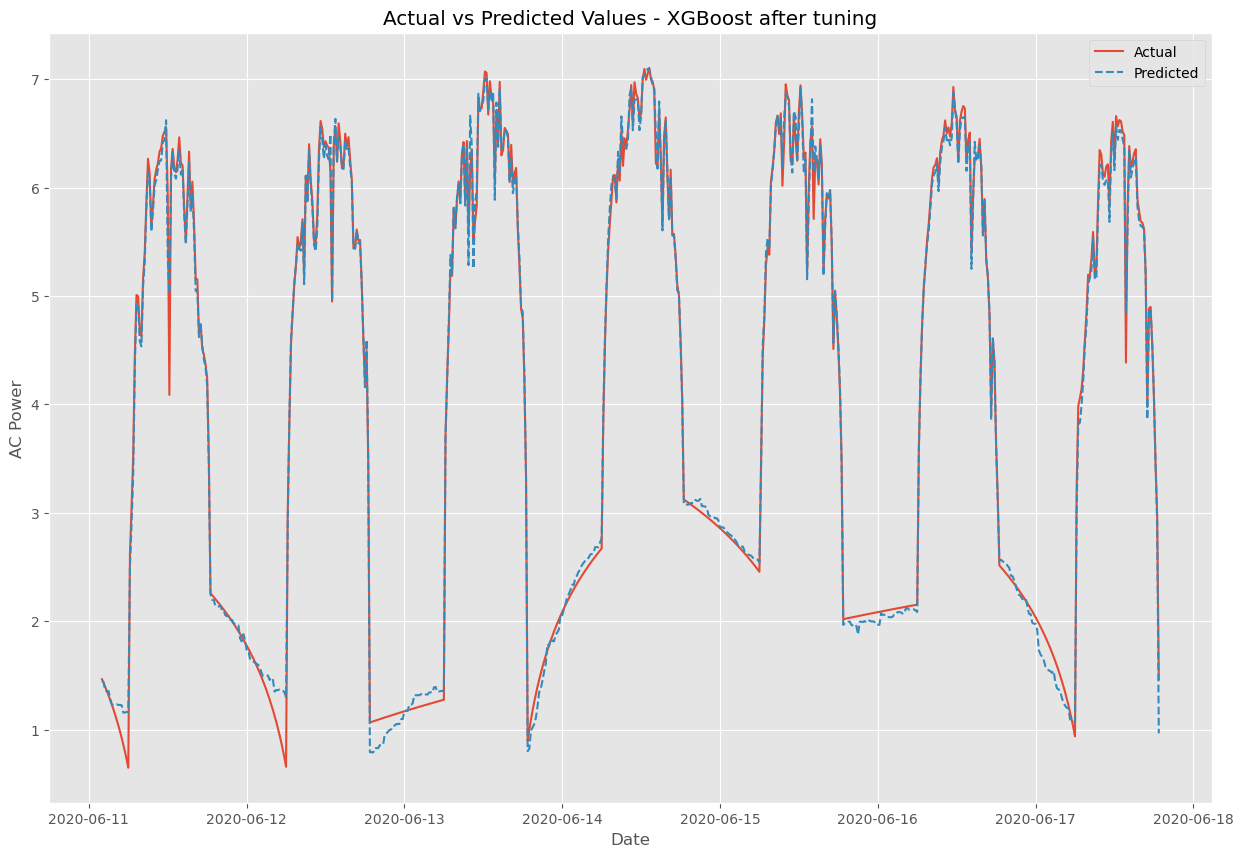

In [60]:
# Plot the predictions against the actual values for XGBoost
plt.figure(figsize=(15,10))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_xgb, linestyle='dashed', label='Predicted')
plt.title('Actual vs Predicted Values - XGBoost after tuning')
plt.legend()
plt.xlabel('Date')
plt.ylabel('AC Power')
plt.show()

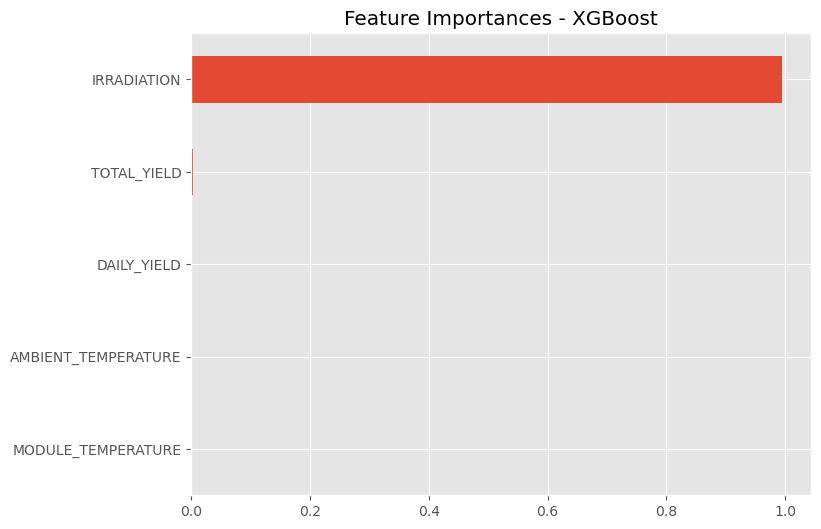

In [61]:
# Get feature importances from the trained Random Forest model
importances = best_xgb_model.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names)
feature_importances.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title('Feature Importances - XGBoost')
plt.show()

* IRRADIATION is the most critical feature by far, indicating it has the highest impact on the model's predictions. This makes sense as solar power generation is directly influenced by the amount of solar irradiation.
* TOTAL_YIELD has minimal impact on the model's predictions. This might be because it is a cumulative measure and does not provide immediate information about the current state of power generation.

<a id="Model-Comparison"></a>
## 3.8 Model Comparison: Evaluating Performance Metrics

In [62]:
# Create a dictionary with the model results
data = {
    'Model': ['SARIMA', 'Random Forest', 'XGBoost'],
    'RMSE': [0.608, 0.165, 0.125],
    'MAPE': [20.570, 4.665, 4.065],
    'CV RMSE Score on Testing Set': ['-', '10-fold: 0.1035', '10-fold: 0.0789'],
    'Training Time (minutes)': [143, 6, 1],
    'Best Parameters': ['order=(1,1,1), seasonal_order=(0,1,1,96)', 
                        'max_features=sqrt, n_estimators=300', 
                        'max_depth=5, learning_rate=0.1, n_estimators=300'],
    'CV Standard Deviation': ['-', 0.0405, 0.0318]
}

# Set the title
title = "Comparison of Models"

# Create a DataFrame
df = pd.DataFrame(data)

# Display the title and the DataFrame
print(title)
df


Comparison of Models


,Model,RMSE,MAPE,CV RMSE Score on Testing Set,Training Time (minutes),Best Parameters,CV Standard Deviation
0,SARIMA,0.608,20.570,-,143,"order=(1,1,1), seasonal_order=(0,1,1,96)",-
1,Random Forest,0.165,4.665,10-fold: 0.1035,6,"max_features=sqrt, n_estimators=300",0.0405
2,XGBoost,0.125,4.065,10-fold: 0.0789,1,"max_depth=5, learning_rate=0.1, n_estimators=300",0.0318


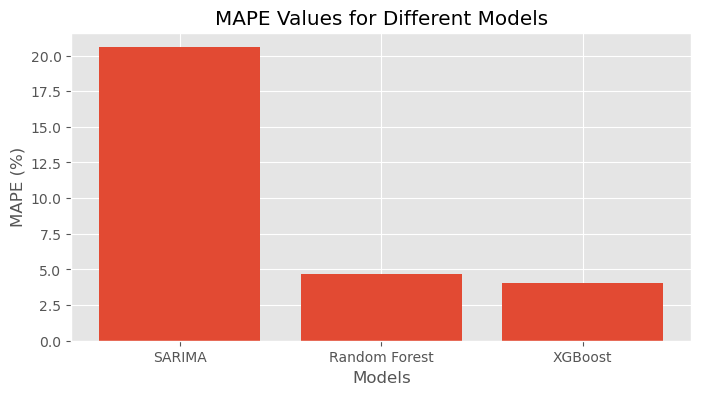

In [63]:
# Data for the bar plot
models = ['SARIMA', 'Random Forest', 'XGBoost']
mape_values = [20.570, 4.653, 4.065]

# Create a bar plot
plt.figure(figsize=(8, 4))
plt.bar(models, mape_values)
plt.title('MAPE Values for Different Models')
plt.xlabel('Models')
plt.ylabel('MAPE (%)')
plt.show()

In comparing the SARIMA, Random Forest, and XGBoost models, XGBoost stands out with the lowest RMSE (0.125) and MAPE (4.065%), indicating superior predictive accuracy. It also exhibits the best cross-validation performance with a mean RMSE score of 0.0789 and the lowest standard deviation (0.0318), suggesting consistent performance across different data splits. Furthermore, XGBoost is more efficient, with a training time of 4 minutes compared to Random Forest's 1 minute. Despite tuning, the Random Forest model has higher RMSE (0.160) and MAPE (4.620%) values, while SARIMA shows the least favorable performance with the highest RMSE (0.608) and MAPE (20.570%). Therefore, XGBoost is recommended for its accuracy, efficiency, and stability, making it the best choice for predictive tasks in this dataset.